In [1]:
import os
from keras.layers import Layer, Input, GlobalAveragePooling2D, Lambda, Dense
from keras.layers import ConvLSTM2D, Conv2D, AveragePooling2D, BatchNormalization
from keras.constraints import unit_norm, non_neg
from keras.activations import softmax
from keras.models import Model
from keras.initializers import Constant
from keras.constraints import Constraint
from keras import backend as K
from keras.layers.convolutional import _Conv
from keras.legacy import interfaces
from keras.engine import InputSpec
import tensorflow as tf
import numpy as np 
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
class Conv2DSymPadding( _Conv ) :
    @interfaces.legacy_conv2d_support
    def __init__(self, filters,
                 kernel_size,
                 strides=(1, 1),
                 data_format=None,
                 dilation_rate=(1, 1),
                 activation=None,
                 padding='same',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(Conv2DSymPadding, self).__init__(
            rank=2,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding='same',
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
        self.input_spec = InputSpec(ndim=4)
    def get_config(self):
        config = super(Conv2DSymPadding, self).get_config()
        config.pop('rank')
        return config
    def call( self, inputs ) :
        if ( isinstance( self.kernel_size, tuple ) ) :
            kh, kw = self.kernel_size
        else :
            kh = kw = self.kernel_size
        ph, pw = kh//2, kw//2
        inputs_pad = tf.pad( inputs, [[0,0],[ph,ph],[pw,pw],[0,0]], mode='symmetric' )
        outputs = K.conv2d(
                inputs_pad,
                self.kernel,
                strides=self.strides,
                padding='valid',
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

In [3]:
class BayarConstraint( Constraint ) :
    def __init__( self ) :
        self.mask = None
    def _initialize_mask( self, w ) :
        nb_rows, nb_cols, nb_inputs, nb_outputs = K.int_shape(w)
        m = np.zeros([nb_rows, nb_cols, nb_inputs, nb_outputs]).astype('float32')
        m[nb_rows//2,nb_cols//2] = 1.
        self.mask = K.variable( m, dtype='float32' )
        return
    def __call__( self, w ) :
        if self.mask is None :
            self._initialize_mask(w)
        w *= (1-self.mask)
        rest_sum = K.sum( w, axis=(0,1), keepdims=True)
        w /= rest_sum + K.epsilon()
        w -= self.mask
        return w

In [4]:
# define ii layer

class IlluminationInvariant(Layer):
    # constructor
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(IlluminationInvariant, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # Create a trainable weight variable alpha for this layer.
        self.alpha = self.add_weight(name='alpha', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(IlluminationInvariant, self).build(input_shape)  # Be sure to call this at the end

    def call(self, img):
        assert isinstance(img, np.ndarray)
        assert(img.shape[2] == 3)
        tmp = (0.5 + K.log(img[:, :, 1] / float(255)) -
                self.alpha * K.log(img[:, :, 2] / float(255)) -
                (1 - self.alpha) * K.log(img[:, :, 0] / float(255)))
        return tmp

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [5]:
# illumination invariant computation
def rgb2ii(img, alpha):
    """Convert RGB image to illumination invariant image."""
    ii_image = (0.5 + np.log(img[:, :, 1] / float(255)) -
                alpha * np.log(img[:, :, 2] / float(255)) -
                (1 - alpha) * np.log(img[:, :, 0] / float(255)))
    return ii_image

In [6]:
class CombinedConv2D(Conv2DSymPadding) :
    def __init__(self, filters,
                 select = 'all',
                 kernel_size=(5,5),
                 strides=(1,1),
                 data_format=None,
                 dilation_rate=(1,1),
                 activation=None,
                 padding='same',
                 use_bias=False,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        self.select = select
        super(CombinedConv2D, self).__init__(
            filters=filters,
            kernel_size=(5,5),
            strides=strides,
            padding='same',
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=False,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=None,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=None,
            **kwargs)
        self.input_spec = InputSpec(ndim=4)
        
    def _get_srm_list( self ) :
        # srm kernel 1                                                                                                                                
        srm1 = np.zeros([5,5]).astype('float32')
        srm1[1:-1,1:-1] = np.array([[-1, 2, -1],
                                    [2, -4, 2],
                                    [-1, 2, -1]] )
        srm1 /= 4.
        # srm kernel 2                                                                                                                                
        srm2 = np.array([[-1, 2, -2, 2, -1],
                         [2, -6, 8, -6, 2],
                         [-2, 8, -12, 8, -2],
                         [2, -6, 8, -6, 2],
                         [-1, 2, -2, 2, -1]]).astype('float32')
        srm2 /= 12.
        # srm kernel 3                                                                                                                                
        srm3 = np.zeros([5,5]).astype('float32')
        srm3[2,1:-1] = np.array([1,-2,1])
        srm3 /= 2.
        return [ srm1, srm2, srm3 ]
    
    def _build_SRM_kernel( self ) :
        kernel = []
        srm_list = self._get_srm_list()
        for idx, srm in enumerate( srm_list ):
            for ch in range(3) :
                this_ch_kernel = np.zeros([5,5,3]).astype('float32')
                this_ch_kernel[:,:,ch] = srm
                kernel.append( this_ch_kernel )
        kernel = np.stack( kernel, axis=-1 )
        srm_kernel = K.variable( kernel, dtype='float32', name='srm' )
        return srm_kernel
    
    def build( self, input_shape ) :
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise( ValueError, 'The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        
        # 1. regular conv kernels, fully trainable                                                                                                    
        filters = self.filters - 9 - 3
        if filters >= 1 :
            regular_kernel_shape = self.kernel_size + (input_dim, filters)
            self.regular_kernel = self.add_weight(shape=regular_kernel_shape,
                                          initializer=self.kernel_initializer,
                                          name='regular_kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        else :
            self.regular_kernel = None
            
        # 2. SRM kernels, not trainable                                                                  
        self.srm_kernel = self._build_SRM_kernel()
        
        # 3. bayar kernels, trainable but under constraint                                                                                            
        bayar_kernel_shape = self.kernel_size + (input_dim, 3)
        self.bayar_kernel = self.add_weight(shape=bayar_kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='bayar_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=BayarConstraint())
        
        # 5. II kernels, trainable parameters
        #ii_kernel_shape = self.alpha
        
        # 6. collect all kernels
        if ( self.regular_kernel is not None ) :
            if self.select is 'all':
                all_kernels = [ self.regular_kernel,
                                self.srm_kernel,
                                self.bayar_kernel]
            elif self.select is 'reg':
                all_kernels = [self.regular_kernel]
            elif self.select is 'srm':
                all_kernels = [self.srm_kernel]
            elif self.select is 'bayar':
                all_kernels = [self.bayar_kernel]
            else :
                all_kernels = [ self.srm_kernel,
                                self.bayar_kernel]
        self.kernel = K.concatenate( all_kernels, axis=-1 )
        
        # Set input spec.                                                                                                                             
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

In [7]:
def create_featex_vgg7_base( type=1 ) :
    base = 4
    img_input = Input(shape=(None,None,3), name='image_in')
    # block 1
    bname = 'b1' # 32
    nb_filters = base
    x = CombinedConv2D( 32 if type in [0,1] else 16, activation='relu', use_bias=False, padding='same', name=bname+'c1')( img_input )
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c2')( x )
    # block 2
    bname = 'b2'
    nb_filters = 2 * base # 64
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c1')( x )
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c2')( x )
    # block 3
    bname = 'b3'
    nb_filters = 4 * base # 96
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c1')( x )
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c2')( x )
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c3')( x )
    # block 4
    bname = 'b4'
    nb_filters = 8 * base # 128
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c1')( x )
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c2')( x )
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c3')( x )
    # block 5/bottle-neck 
    bname = 'b5'
    activation=None if type >=1 else 'tanh'
    print ("INFO: use activation in the last CONV={}".format( activation ))
    sf = Conv2DSymPadding( nb_filters, (3,3),
                           activation=activation,
                          name='transform',
                          padding='same' )(x)
    sf = Lambda( lambda t : K.l2_normalize( t, axis=-1), name='L2')(sf)
    return Model( inputs= img_input, outputs=sf, name='Featex')

class GlobalStd2D( Layer ) :
    '''Custom Keras Layer to compute sample-wise feature deviation
    '''
    def __init__( self, min_std_val=1e-5, **kwargs ) :
        self.min_std_val = min_std_val
        super( GlobalStd2D, self ).__init__( **kwargs )
    def build( self, input_shape ) :
        nb_feats = input_shape[-1]
        std_shape = ( 1,1,1, nb_feats )
        self.min_std = self.add_weight( shape=std_shape,
                                        initializer=Constant(self.min_std_val),
                                        name='min_std',
                                        constraint=non_neg() )
        self.built = True
        return
    def call( self, x ) :
        x_std = K.std( x, axis=(1,2), keepdims=True )
        x_std = K.maximum( x_std, self.min_std_val/10. + self.min_std )
        return x_std
    def compute_output_shape( self, input_shape ) :
        return (input_shape[0], 1, 1, input_shape[-1] )

class NestedWindowAverageFeatExtrator( Layer ) :
    '''Custom Keras Layer of NestedWindowAverageFeatExtrator
    '''
    def __init__( self,
                  window_size_list,
                  output_mode='5d',
                  minus_original=False,
                  include_global=True,
                  **kwargs ) :
        '''
        INPUTS:
            win_size_list = list of int or tuples, each elem indicate a winsize of interest
            output_mode = '5d' or '4d', where
                          '5d' merges all win_avgs along a new time axis
                          '4d' merges all win_avgs along the existing feat axis
        '''
        self.window_size_list = window_size_list
        assert output_mode in ['5d','4d'], "ERROR: unkown output mode={}".format( output_mode )
        self.output_mode = output_mode
        self.minus_original = minus_original
        self.include_global = include_global
        super(NestedWindowAverageFeatExtrator, self).__init__(**kwargs)
        
    def build( self, input_shape ) :
        self.num_woi = len( self.window_size_list )
        self.count_ii = None
        self.lut = dict()
        self.built = True
        self.max_wh, self.max_ww = self._get_max_size()
        return
    
    def _initialize_ii_buffer( self, x ) :
        x_pad = K.spatial_2d_padding( x, ((self.max_wh//2+1,self.max_wh//2+1), (self.max_ww//2+1,self.max_ww//2+1)) )
        ii_x  = K.cumsum( x_pad, axis=1 )
        ii_x2 = K.cumsum( ii_x, axis=2 )
        return ii_x2
    
    def _get_max_size( self ) :
        mh, mw = 0, 0
        for hw in self.window_size_list :
            if ( isinstance( hw, int ) ) :
                h = w = hw
            else :
                h, w = hw[:2]
            mh = max( h, mh )
            mw = max( w, mw )
        return mh, mw
    
    def _compute_for_one_size( self, x, x_ii, height, width ) :
        # 1. compute valid counts for this key
        top   = self.max_wh//2 - height//2
        bot   = top + height
        left  = self.max_ww//2 - width //2
        right = left + width
        Ay, Ax = (top, left) #self.max_wh, self.max_ww
        By, Bx = (top, right) # Ay, Ax + width
        Cy, Cx = (bot, right) #By + height, Bx
        Dy, Dx = (bot, left) #Cy, Ax
        ii_key = (height,width)
        top_0   = -self.max_wh//2 - height//2 - 1
        bot_0   = top_0 + height
        left_0  = -self.max_ww//2 - width//2 - 1
        right_0 = left_0 + width
        Ay0, Ax0 = (top_0, left_0) #self.max_wh, self.max_ww
        By0, Bx0 = (top_0, right_0) # Ay, Ax + width
        Cy0, Cx0 = (bot_0, right_0) #By + height, Bx
        Dy0, Dx0 = (bot_0, left_0) #Cy, Ax
        # used in testing, where each batch is a sample of different shapes
        counts = K.ones_like( x[:1,...,:1] )
        count_ii = self._initialize_ii_buffer( counts )
        # compute winsize if necessary
        counts_2d = count_ii[:,Ay:Ay0, Ax:Ax0] \
                  + count_ii[:,Cy:Cy0, Cx:Cx0] \
                  - count_ii[:,By:By0, Bx:Bx0] \
                  - count_ii[:,Dy:Dy0, Dx:Dx0]
        # 2. compute summed feature
        sum_x_2d = x_ii[:,Ay:Ay0, Ax:Ax0] \
                 + x_ii[:,Cy:Cy0, Cx:Cx0] \
                 - x_ii[:,By:By0, Bx:Bx0] \
                 - x_ii[:,Dy:Dy0, Dx:Dx0]
        # 3. compute average feature
        avg_x_2d = sum_x_2d / counts_2d
        return avg_x_2d
    
    def call( self, x ) :
        x_win_avgs = []
        # 1. compute corr(x, window_mean) for different sizes
        # 1.1 compute integral image buffer
        x_ii = self._initialize_ii_buffer( x )
        for hw in self.window_size_list :
            if isinstance( hw, int ) :
                height = width = hw
            else :
                height, width = hw[:2]
            this_avg = self._compute_for_one_size( x, x_ii, height, width )
            if ( self.minus_original ) :
                x_win_avgs.append( this_avg-x )
            else :
                x_win_avgs.append( this_avg )
        # 2. compute corr(x, global_mean)
        if ( self.include_global ) :
            if ( self.minus_original ) :
                mu = K.mean( x, axis=(1,2), keepdims=True )
                x_win_avgs.append( mu-x )
            else :
                mu = K.mean( x, axis=(1,2), keepdims=True ) * K.ones_like(x)
                x_win_avgs.append( mu )
        if self.output_mode == '4d' :
            return K.concatenate( x_win_avgs, axis=-1 )
        elif self.output_mode == '5d' :
            return K.stack( x_win_avgs, axis=1 )
        else :
            raise (NotImplementedError, "ERROR: unknown output_mode={}".format( self.output_mode ))
            
    def compute_output_shape(self, input_shape):
        batch_size, num_rows, num_cols, num_filts = input_shape
        if self.output_mode == '4d' :
            return ( batch_size, num_rows, num_cols, (self.num_woi+int(self.include_global))*num_filts )
        else :
            return ( batch_size, self.num_woi+int(self.include_global), num_rows, num_cols, num_filts )

def create_manTraNet_model( Featex, pool_size_list=[7,15,31], is_dynamic_shape=True, apply_normalization=True ) :
    """
    Create ManTra-Net from a pretrained IMC-Featex model
    """
    img_in = Input(shape=(None,None,3), name='img_in' )
    rf = Featex( img_in )
    rf = Conv2D( 64, (1,1),
                 activation=None, # no need to use tanh if sf is L2normalized
                 use_bias=False,
                 kernel_constraint = unit_norm( axis=-2 ),
                 name='outlierTrans',
                 padding = 'same' )(rf)
    bf = BatchNormalization( axis=-1, name='bnorm', center=False, scale=False )(rf)
    devf5d = NestedWindowAverageFeatExtrator(window_size_list=pool_size_list,
                                             output_mode='5d',
                                             minus_original=True,
                                             name='nestedAvgFeatex' )( bf )
    if ( apply_normalization ) :
        sigma = GlobalStd2D( name='glbStd' )( bf )
        sigma5d = Lambda( lambda t : K.expand_dims( t, axis=1 ), name='expTime')( sigma )
        devf5d = Lambda( lambda vs : K.abs(vs[0]/vs[1]), name='divStd' )([devf5d, sigma5d])
    # convert back to 4d
    devf = ConvLSTM2D( 8, (7,7),
                       activation='tanh',
                       recurrent_activation='hard_sigmoid',
                       padding='same',
                       name='cLSTM',
                       return_sequences=False )(devf5d)
    pred_out = Conv2D(1, (7,7), padding='same', activation='sigmoid', name='pred')( devf )
    return Model( inputs=img_in, outputs=pred_out, name='sigNet' )

def create_model( IMC_model_idx, freeze_featex, window_size_list ) :
    type_idx = IMC_model_idx if IMC_model_idx < 4 else 2
    Featex = create_featex_vgg7_base( type_idx )
    if freeze_featex :
        print ("INFO: freeze feature extraction part, trainable=False")
        Featex.trainable = False
    else :
        print ("INFO: unfreeze feature extraction part, trainable=True")

    if ( len( window_size_list ) == 4 ) :
        for ly in Featex.layers[:5] :
            ly.trainable = False
            print ("INFO: freeze", ly.name)
    model = create_manTraNet_model( Featex,
                                    pool_size_list=window_size_list,
                                    is_dynamic_shape=True,
                                    apply_normalization=True, )
    return model

def load_pretrain_model_by_index( pretrain_index, model_dir ) :
    if ( pretrain_index == 4 ) :
        IMC_model_idx, freeze_featex, window_size_list  = 2, False, [7, 15, 31]
    else :
        IMC_model_idx, freeze_featex, window_size_list  = pretrain_index, False, [7, 15, 31, 63]
    single_gpu_model = create_model( IMC_model_idx, freeze_featex, window_size_list )
    weight_file = "{}/ManTraNet_Ptrain{}.h5".format( model_dir, pretrain_index )
    assert os.path.isfile(weight_file), "ERROR: fail to locate the pretrained weight file"
    single_gpu_model.load_weights( weight_file )
    return single_gpu_model


In [8]:
import os
import numpy as np 
import cv2
import requests
import sys

from PIL import Image
from io import BytesIO
from matplotlib import pyplot

In [9]:
os.chdir('/home/ubuntu/')
manTraNet_root = './ManTraNet/'
manTraNet_srcDir = os.path.join( manTraNet_root, 'src' )
sys.path.insert( 0, manTraNet_srcDir )
manTraNet_modelDir = os.path.join( manTraNet_root, 'pretrained_weights' )
manTraNet_dataDir = os.path.join( manTraNet_root, 'data' )


os.chdir('/home/ubuntu/')
#manTraNet = load_pretrain_model_by_index(1, manTraNet_modelDir)
single_gpu_model = create_model(2, False, [7, 15, 31])
single_gpu_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
single_gpu_model.summary()



INFO: use activation in the last CONV=None
INFO: unfreeze feature extraction part, trainable=True





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Featex (Model)                  (None, None, None, 3 40177       img_in[0][0]                     
__________________________________________________________________________________________________
outlierTrans (Conv2D)           (None, None, None, 6 2048        Featex[1][0]                     
__________________________________________________________________________________________________
bnorm (Ba

In [10]:
X_train = np.load('X_train_2.npy')
Y_train = np.load('Y_train_2.npy')

In [ ]:
filepath = "output/vgg7_small_endtoend_data2-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
single_gpu_model.fit(X_train, Y_train, epochs=20, batch_size=10, callbacks = [checkpoint])

In [11]:
os.chdir('/home/ubuntu/')

#manTraNet = load_pretrain_model_by_index(1, manTraNet_modelDir)
single_gpu_model = create_model(2, False, [7, 15, 31])
weight_file = "output/vgg7_small_endtoend_data2-20.hdf5"
single_gpu_model.load_weights( weight_file )
single_gpu_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
single_gpu_model.summary()

INFO: use activation in the last CONV=None
INFO: unfreeze feature extraction part, trainable=True
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Featex (Model)                  (None, None, None, 3 40177       img_in[0][0]                     
__________________________________________________________________________________________________
outlierTrans (Conv2D)           (None, None, None, 6 2048        Featex[1][0]                     
__________________________________________________________________________________________________
bnorm (BatchNormalization)      (None, None, None, 6 128         outlierTrans[0][0]               
___________

In [12]:
X_test = np.load('X_test_1.npy')
Y_test = np.load('Y_test_1.npy')
preds = single_gpu_model.evaluate(X_test, Y_test, batch_size=8, verbose=1, sample_weight=None)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1000/1000 [==============================] - 69s 69ms/step

Loss = 0.3726019661426544
Test Accuracy = 0.8961729717254638


In [13]:
y_pred=single_gpu_model.predict(X_test)

In [14]:
Y_test = Y_test.reshape((Y_test.shape[0] * Y_test.shape[1] * Y_test.shape[2]))
Y_test = Y_test > 0.5

In [15]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
Y_pred = y_pred.copy()
Y_pred = Y_pred.reshape((Y_pred.shape[0] * Y_pred.shape[1] * Y_pred.shape[2]))
print(Y_pred.shape, Y_pred.dtype)
print(Y_test.shape, Y_test.dtype)
#cm=confusion_matrix(Y_test,Y_pred)
#print(cm)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred)
AUC = metrics.auc(fpr, tpr)

(50176000,) float32
(50176000,) bool


In [16]:
# export and save data
import scipy.io as sio
sio.savemat('dean2_VGG7_small_data2',{'tpr':tpr, 'fpr':fpr, 'AUC': AUC, 'TestLoss':preds[0], 'TestACC':preds[1]})

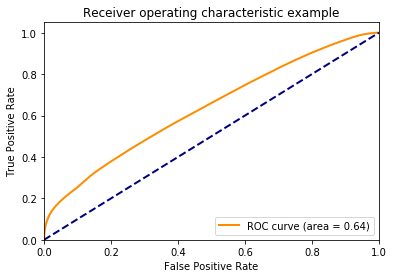

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()